In [9]:
## Load packages and data
#library(dplyr)
library(tableone)
library(MatchIt)
library(pROC)
library(ROCR)
library(ggplot2)
library(epitools)
library(plyr)
library(ipw)
library(sandwich)
library(survey)
library(reshape2)


In [288]:
#load data
kkh_data <- read.csv("pards_data_0830.csv")
#kkh_data <- read.csv("pards_data_0816.csv")
df<-data.frame(kkh_data)
kkh<-df[!is.na(df$d2_oi),]
kkh <- kkh[which(!((kkh$hfv==1)&(kkh$HFV_verify==0))), ]
#kkh <- kkh[which((kkh$Non_CPAP==1)), ]
####check column names
var<-colnames(kkh, do.NULL = FALSE)[1:9]
#head(kkh)

####select features
ID<-kkh$StudyID
female<-as.numeric(kkh$Gender=='Female')
age<-kkh$Age
pim2<-kkh$pim2
pelod<-kkh$pelod
p_bloodculture<-as.numeric(kkh$Positive_blood_culture=='Yes')
early_HFV<-kkh$early_HFV
D1_HFV<-kkh$D1_HFV
D2_HFV<-kkh$D2_HFV
D3_HFV<-kkh$D3_HFV
D4_HFV<-kkh$D4_HFV
D5_HFV<-kkh$D5_HFV
D6_HFV<-kkh$D6_HFV
D7_HFV<-kkh$D7_HFV
ICUadmissiondate <- as.Date(kkh$ICUadmissiondate,format="%d/%m/%Y")
ICUdischargedate <- as.Date(kkh$ICUdischargedate,format="%d/%m/%Y")


#comorbidity
comorbidity<-kkh$comorbidity
#risk factor of ARDS
rf_pneumonia<-as.numeric(kkh$PNEUMONIA=='Checked')
rf_sepsis<-as.numeric(kkh$SEPSIS=='Checked')
rf_aspiration<-as.numeric(kkh$ASPIRATION=='Checked')
rf_transfusion<-as.numeric(kkh$TRANSFUSION=='Checked')
rf_trauma<-as.numeric(kkh$TRAUMA=='Checked')
rf_drowning<-as.numeric(kkh$DROWNING=='Checked')

#other useful features
MODS<-as.numeric(kkh$MODS=='Yes')
OI<-kkh$d2_oi
OI_category<-kkh$OI_category
treatment<-as.numeric(kkh$Received_HFV=='Yes')
died_in_ICU<-kkh$died_in_ICU
mortality_30day<-kkh$mort_30
mortality_28day<-kkh$mort_28
mortality_100day<-kkh$mort_100
ventilation_free_day<-kkh$ventilation_free_day
picu_free_days<-kkh$picu_free_days
fio2<-kkh$avg_fio2max
map<-kkh$avg_mapmax
amplitude<-kkh$avg_amplitudemax


####prepare for the data
mydata<-cbind(ID,female,age,pim2,pelod,p_bloodculture,comorbidity,rf_pneumonia,rf_sepsis,rf_aspiration,rf_transfusion
              ,rf_trauma
              ,rf_drowning,MODS,OI,OI_category
              ,treatment,died_in_ICU,D1_HFV,D2_HFV,D3_HFV,D4_HFV,D5_HFV,D6_HFV,D7_HFV,ICUadmissiondate,ICUdischargedate
              ,mortality_30day,mortality_28day,mortality_100day,ventilation_free_day,picu_free_days, fio2, map, amplitude)


mydata<-data.frame(mydata)
mydata$ICUduration<-mydata$ICUdischargedate-mydata$ICUadmissiondate+1
head(mydata)

ID,female,age,pim2,pelod,p_bloodculture,comorbidity,rf_pneumonia,rf_sepsis,rf_aspiration,⋯,ICUdischargedate,mortality_30day,mortality_28day,mortality_100day,ventilation_free_day,picu_free_days,fio2,map,amplitude,ICUduration
1001,1,0.02,87.3,42,1,0,0,1,0,⋯,-714251,1,1,1,0,0,NA,NA,NA,3
1003,0,0.47,2.8,11,0,0,1,0,0,⋯,-714372,0,0,2,21,26,NA,NA,NA,3
1005,1,0.10,0.6,1,0,0,1,0,0,⋯,-714217,0,0,2,21,20,NA,NA,NA,9
1006,1,1.72,8.2,12,0,0,1,0,0,⋯,-714392,0,0,2,7,0,100,23,70.00000,59
1008,1,2.92,6.8,2,0,1,1,0,0,⋯,-714195,0,0,2,27,24,NA,NA,NA,5
1009,0,0.70,2.8,10,0,1,1,0,0,⋯,-714231,1,1,1,0,0,100,32,43.66667,9


In [260]:
#create new dataset for cox ph model with time-dependent adjustment for treatment and covariates
#df2 is the final dataset
df<-melt(mydata,id.vars=c("ID","ICUduration","died_in_ICU","mortality_30day","mortality_28day","mortality_100day","female","age","pim2","pelod","p_bloodculture",
                          "comorbidity","rf_pneumonia","rf_sepsis","rf_aspiration","rf_transfusion", 
                          "rf_trauma", "rf_drowning","MODS","OI"), 
         measure.vars=c("D1_HFV","D2_HFV","D3_HFV","D4_HFV","D5_HFV","D6_HFV","D7_HFV"),
         variable.name = "end_day",value.name = "HFV_indicator",factorsAsStrings = FALSE)

df<-df[order(df$ID), , drop = FALSE]
df$end_day<-revalue(df$end_day, c("D1_HFV"=1,"D2_HFV"=2, "D3_HFV"=3,"D4_HFV"=4,"D5_HFV"=5, "D6_HFV"=6,"D7_HFV"=7))
df$end_day<-as.numeric(df$end_day)
df$start_day<-df$end_day-1

df1<-df[df$start_day<df$ICUduration,]
df1$event<-ifelse(df1$end_day<df1$ICUduration, 0,df1$died_in_ICU)

df1 <- df1[c("ID","start_day","end_day","HFV_indicator","event","died_in_ICU","mortality_28day","ICUduration","female","age","pim2","pelod","p_bloodculture","comorbidity","rf_pneumonia"
         ,"rf_sepsis","rf_aspiration" , "rf_transfusion", "rf_trauma", "rf_drowning","MODS","OI")]


length(df1$ID)
df2 <- do.call("rbind", lapply(unique(df1$ID), function(id) {
    df1_id <- df1[df1$ID == id, ]
    n_id <- nrow(df1_id)
    n_all <- df1_id$ICUduration[1]
    if(n_all>28){
        n_all<-28
    }
    if (n_id == n_all) {
        df1_id
    } else {
        last_row <- df1_id[n_id, ]
        df1_add <- do.call("rbind", lapply((n_id + 1):n_all, function(r) {
            new_row <- last_row
            new_row$start_day <- r - 1
            new_row$end_day <- r
            new_row$HFV_indicator<-0
            if(r==n_all){
                new_row$event<- new_row$mortality_28day
            } else{
                new_row$event<- 0
            }
            new_row
        }))
        rbind(df1_id, df1_add)
    }
}))
df2[1:70,]

[1] 2162

,ID,start_day,end_day,HFV_indicator,event,died_in_ICU,mortality_28day,ICUduration,female,age,⋯,p_bloodculture,comorbidity,rf_pneumonia,rf_sepsis,rf_aspiration,rf_transfusion,rf_trauma,rf_drowning,MODS,OI
1,1001,0,1,0,0,1,1,3,1,0.02,⋯,1,0,0,1,0,0,0,0,1,5.06
329,1001,1,2,0,0,1,1,3,1,0.02,⋯,1,0,0,1,0,0,0,0,1,5.06
657,1001,2,3,0,1,1,1,3,1,0.02,⋯,1,0,0,1,0,0,0,0,1,5.06
2,1003,0,1,0,0,0,0,3,0,0.47,⋯,0,0,1,0,0,0,0,0,0,5.11
330,1003,1,2,0,0,0,0,3,0,0.47,⋯,0,0,1,0,0,0,0,0,0,5.11
658,1003,2,3,0,0,0,0,3,0,0.47,⋯,0,0,1,0,0,0,0,0,0,5.11
3,1005,0,1,0,0,0,0,9,1,0.10,⋯,0,0,1,0,0,0,0,0,0,8.01
331,1005,1,2,0,0,0,0,9,1,0.10,⋯,0,0,1,0,0,0,0,0,0,8.01
659,1005,2,3,0,0,0,0,9,1,0.10,⋯,0,0,1,0,0,0,0,0,0,8.01
987,1005,3,4,0,0,0,0,9,1,0.10,⋯,0,0,1,0,0,0,0,0,0,8.01


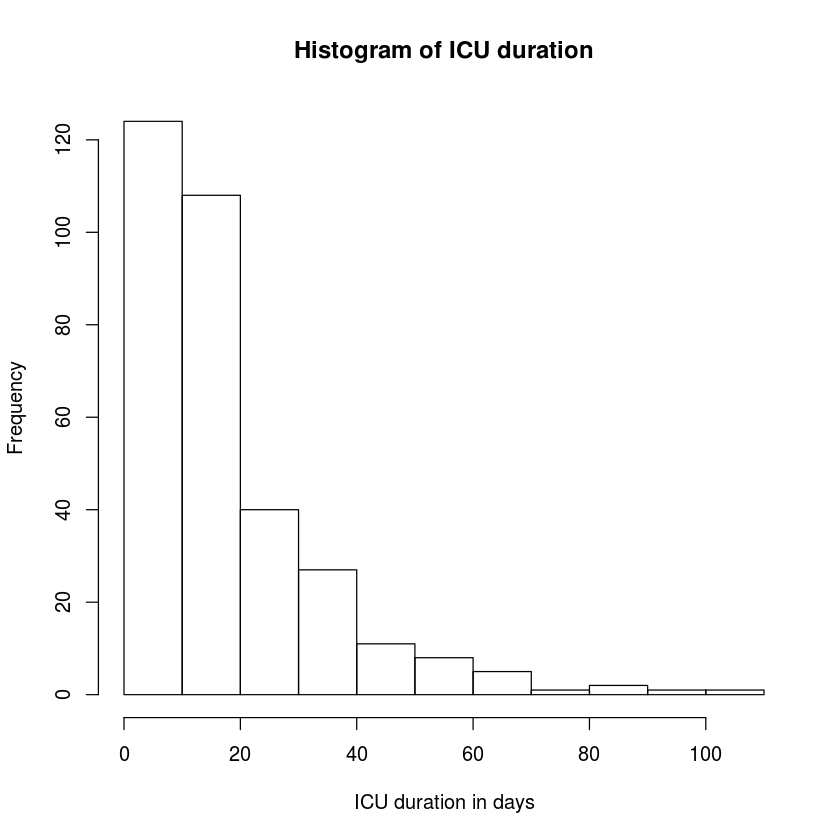

In [261]:
#look at ICU duration distribution
hist(mydata$ICUduration, main="Histogram of ICU duration",xlab="ICU duration in days")

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.4543  0.9666  1.1550  1.2310  1.2933  5.4262 

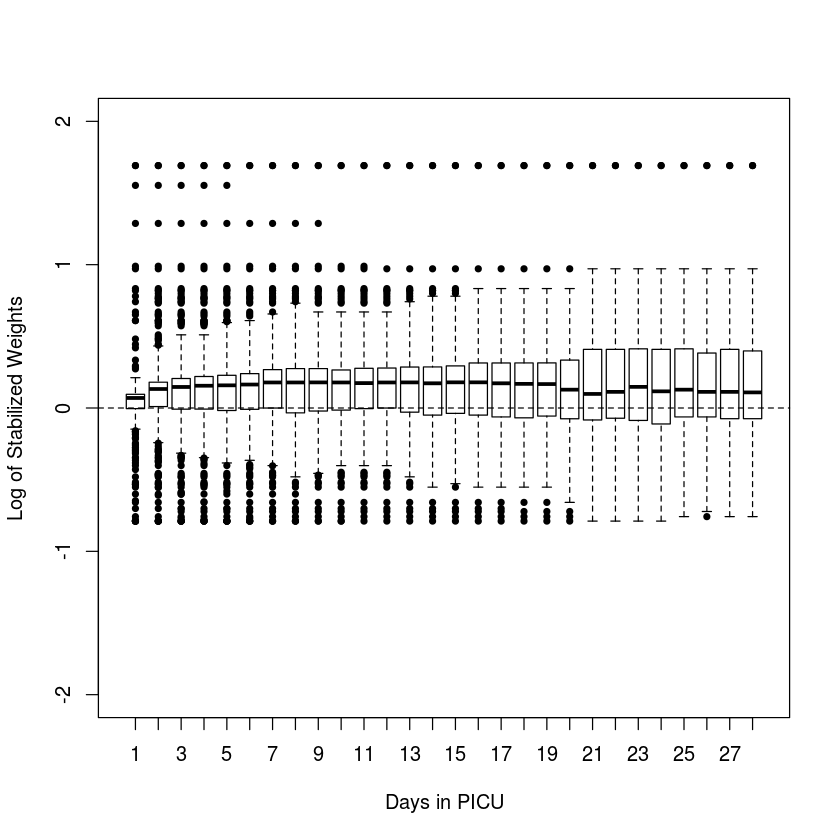

In [263]:
# stabilized weights for MSM Cox PH model
time_model <- ipwtm(
  exposure = HFV_indicator,
  family = "survival",

  numerator = ~ female+age+pim2+pelod+p_bloodculture+comorbidity+rf_pneumonia+rf_sepsis
                 +rf_aspiration+rf_transfusion+rf_drowning+MODS+OI,
  denominator = ~1,
  id = ID,
  tstart = start_day,
  timevar = end_day,
  type = "first",
  data = df2, trunc=0.01)
summary(time_model$weights.trunc)


#plot (stabilized) inverse probability weights

#png(filename="sw_plot.png")
ipwplot(weights = time_model$weights.trunc, timevar = df2$end_day, xlab="Days in PICU", ylab="Log of Stabilized Weights",
   binwidth = 1, ylim=c(-2,2))
#dev.off()

In [264]:
#MSM Cox PH model with adjustment for covariates
cox_model<-coxph(Surv(start_day, end_day, event) ~ HFV_indicator+female+age+pim2+pelod+p_bloodculture+comorbidity+rf_pneumonia+rf_sepsis
                 +rf_aspiration+rf_transfusion+rf_drowning+MODS+OI+cluster(ID),
   data = df2, weights = time_model$weights.trunc)
summary(cox_model)


Call:
coxph(formula = Surv(start_day, end_day, event) ~ HFV_indicator + 
    female + age + pim2 + pelod + p_bloodculture + comorbidity + 
    rf_pneumonia + rf_sepsis + rf_aspiration + rf_transfusion + 
    rf_drowning + MODS + OI + cluster(ID), data = df2, weights = time_model$weights.trunc)

  n= 5020, number of events= 79 

                    coef exp(coef)  se(coef) robust se      z Pr(>|z|)    
HFV_indicator  -0.577200  0.561468  0.400955  0.536495 -1.076   0.2820    
female          0.087194  1.091108  0.227071  0.307817  0.283   0.7770    
age            -0.017494  0.982658  0.024576  0.030905 -0.566   0.5714    
pim2           -0.013837  0.986258  0.005258  0.008284 -1.670   0.0948 .  
pelod           0.062193  1.064167  0.012410  0.015107  4.117 3.84e-05 ***
p_bloodculture  0.471108  1.601767  0.276323  0.317959  1.482   0.1384    
comorbidity    -0.085685  0.917883  0.221815  0.275301 -0.311   0.7556    
rf_pneumonia    0.089721  1.093869  0.316805  0.418915  0.214   0.8304

In [265]:
#MSM Cox PH model without adjustment for covariates
cox_model<-coxph(Surv(start_day, end_day, event) ~ HFV_indicator + cluster(ID),
   data = df2, weights = time_model$weights.trunc)
summary(cox_model)

Call:
coxph(formula = Surv(start_day, end_day, event) ~ HFV_indicator + 
    cluster(ID), data = df2, weights = time_model$weights.trunc)

  n= 5020, number of events= 79 

                 coef exp(coef) se(coef) robust se      z Pr(>|z|)
HFV_indicator -0.2465    0.7815   0.3581    0.5617 -0.439    0.661

              exp(coef) exp(-coef) lower .95 upper .95
HFV_indicator    0.7815       1.28    0.2599      2.35

Concordance= 0.513  (se = 0.021 )
Rsquare= 0   (max possible= 0.192 )
Likelihood ratio test= 0.49  on 1 df,   p=0.5
Wald test            = 0.19  on 1 df,   p=0.7
Score (logrank) test = 0.48  on 1 df,   p=0.5,   Robust = 0.23  p=0.6

  (Note: the likelihood ratio and score tests assume independence of
     observations within a cluster, the Wald and robust score tests do not).

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.070   1.279   1.596   6.102   5.670  55.647 

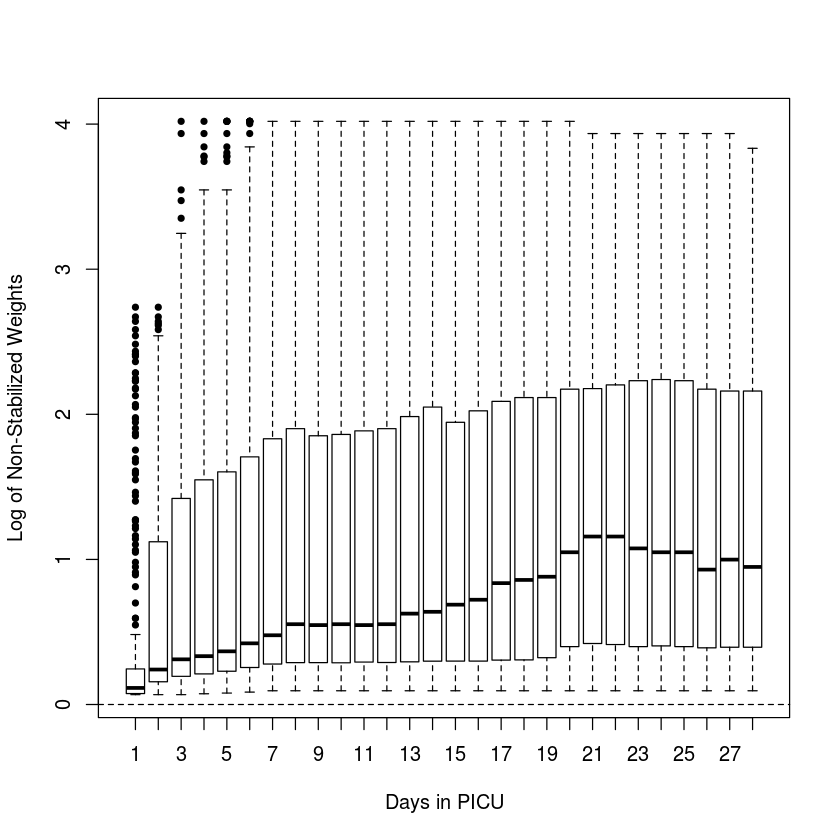

In [277]:
#non-stabilized weight
time_model <- ipwtm(
  exposure = HFV_indicator,
  family = "survival",
  #numerator = ~ 1,
  denominator = ~ female+age+pim2+pelod+p_bloodculture+comorbidity+rf_pneumonia+rf_sepsis
                 +rf_aspiration+rf_transfusion+rf_drowning+MODS+OI,
  id = ID,
  tstart = start_day,
  timevar = end_day,
  type = "first",
  data = df2, trunc=0.01)
summary(time_model$weights.trunc)

#plot non-stabilized inverse probability weights

#png(filename="non_sw_plot.png")
ipwplot(weights = time_model$weights.trunc, timevar = df2$end_day, xlab="Days in PICU", ylab="Log of Non-Stabilized Weights",
   binwidth = 1)
#dev.off()

In [278]:
#Conditional Cox PH model without adjustment for covariates
cox_model<-coxph(Surv(start_day, end_day, event) ~ HFV_indicator + cluster(ID),
   data = df2,weights = time_model$weights.trunc)
summary(cox_model)


Call:
coxph(formula = Surv(start_day, end_day, event) ~ HFV_indicator + 
    cluster(ID), data = df2, weights = time_model$weights.trunc)

  n= 5020, number of events= 79 

                 coef exp(coef) se(coef) robust se      z Pr(>|z|)
HFV_indicator -0.8128    0.4436   0.1505    0.6365 -1.277    0.202

              exp(coef) exp(-coef) lower .95 upper .95
HFV_indicator    0.4436      2.254    0.1274     1.545

Concordance= 0.524  (se = 0.005 )
Rsquare= 0.006   (max possible= 0.9 )
Likelihood ratio test= 28.76  on 1 df,   p=8e-08
Wald test            = 1.63  on 1 df,   p=0.2
Score (logrank) test = 30.8  on 1 df,   p=3e-08,   Robust = 1.84  p=0.2

  (Note: the likelihood ratio and score tests assume independence of
     observations within a cluster, the Wald and robust score tests do not).

In [279]:
#Conditional Cox PH model with adjustment of covariates
cox_model<-coxph(Surv(start_day, end_day, event) ~ HFV_indicator+female+age+pim2+pelod+p_bloodculture+comorbidity+rf_pneumonia+rf_sepsis
                 +rf_aspiration+rf_transfusion+rf_drowning+MODS+OI+cluster(ID),
   data = df2,weights = time_model$weights.trunc)
summary(cox_model)


Call:
coxph(formula = Surv(start_day, end_day, event) ~ HFV_indicator + 
    female + age + pim2 + pelod + p_bloodculture + comorbidity + 
    rf_pneumonia + rf_sepsis + rf_aspiration + rf_transfusion + 
    rf_drowning + MODS + OI + cluster(ID), data = df2, weights = time_model$weights.trunc)

  n= 5020, number of events= 79 

                    coef exp(coef)  se(coef) robust se      z Pr(>|z|)   
HFV_indicator  -1.027747  0.357812  0.157256  0.747074 -1.376  0.16892   
female         -0.621615  0.537077  0.078383  0.392618 -1.583  0.11336   
age            -0.003209  0.996796  0.009810  0.037347 -0.086  0.93153   
pim2           -0.009916  0.990133  0.002672  0.021676 -0.457  0.64733   
pelod           0.006897  1.006921  0.005220  0.027162  0.254  0.79956   
p_bloodculture  0.280183  1.323372  0.124704  0.545104  0.514  0.60725   
comorbidity     0.332224  1.394064  0.081512  0.486192  0.683  0.49441   
rf_pneumonia    0.223319  1.250219  0.154320  0.638520  0.350  0.72653   
rf_s

In [268]:
#To get table 1 for the weighted cohort
mydata$OI_category<-as.factor(mydata$OI_category)
mydata$OI_category<-C(mydata$OI_category, contr.treatment, base=3)

#fit a propensity score model with logistic regression
psmodel <-glm(treatment~female+age+pim2+pelod+p_bloodculture+comorbidity+rf_pneumonia+rf_sepsis
                 +rf_aspiration+rf_transfusion+rf_trauma+rf_drowning+MODS+OI_category
                 , data = mydata,family=binomial(link="logit"))
#show coefficients etc
summary(psmodel)
xvars<-c("female","age","pim2","pelod","p_bloodculture","comorbidity","rf_pneumonia"
         ,"rf_sepsis","rf_aspiration" , "rf_transfusion", "rf_trauma","rf_drowning","MODS","OI_category"
         )
#create propensity score
pscore<-psmodel$fitted.values
label<-mydata$treatment
perf<- ROCR::prediction(pscore, label)
psm_auc<-ROCR::performance(ROCR::prediction(pscore, label), "auc")@y.values[1]
print(psm_auc)


mydata$weight<-ifelse(treatment==1,1/pscore, 1/(1-pscore))
weighteddata<-svydesign(ids=~1, data= mydata, weights = ~weight)
weighted_table<-svyCreateTableOne(var = xvars, strata ="treatment",
                                data=weighteddata)
print(weighted_table, smd=TRUE)


Call:
glm(formula = treatment ~ female + age + pim2 + pelod + p_bloodculture + 
    comorbidity + rf_pneumonia + rf_sepsis + rf_aspiration + 
    rf_transfusion + rf_trauma + rf_drowning + MODS + OI_category, 
    family = binomial(link = "logit"), data = mydata)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8910  -0.8559  -0.3999   0.8741   2.7032  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -2.792795   0.828242  -3.372 0.000746 ***
female           0.370592   0.282663   1.311 0.189834    
age             -0.006784   0.030804  -0.220 0.825682    
pim2             0.005487   0.008274   0.663 0.507255    
pelod            0.027392   0.017134   1.599 0.109894    
p_bloodculture   0.367778   0.406821   0.904 0.365980    
comorbidity      0.044131   0.291964   0.151 0.879856    
rf_pneumonia     0.324271   0.465904   0.696 0.486427    
rf_sepsis       -0.799148   0.371016  -2.154 0.031245 *  
rf_aspiration   -0.132999 

[[1]]
[1] 0.8140618

                            Stratified by treatment
                             0              1              p      test SMD   
  n                          326.17         350.20                           
  female (mean (sd))           0.49 (0.50)    0.40 (0.49)   0.280       0.176
  age (mean (sd))              4.02 (4.72)    3.52 (4.07)   0.433       0.114
  pim2 (mean (sd))            16.25 (20.58)  16.05 (19.67)  0.950       0.010
  pelod (mean (sd))            9.92 (10.43)  10.06 (9.29)   0.931       0.014
  p_bloodculture (mean (sd))   0.16 (0.36)    0.13 (0.34)   0.574       0.072
  comorbidity (mean (sd))      0.50 (0.50)    0.47 (0.50)   0.696       0.069
  rf_pneumonia (mean (sd))     0.82 (0.38)    0.73 (0.45)   0.374       0.221
  rf_sepsis (mean (sd))        0.29 (0.45)    0.37 (0.48)   0.385       0.181
  rf_aspiration (mean (sd))    0.04 (0.20)    0.03 (0.16)   0.418       0.089
  rf_transfusion (mean (sd))   0.01 (0.10)    0.01 (0.11)   0.772    

In [289]:
#sensitivity analysis
#pairs for the PS matching method
pairs <- read.csv("pair_ID.csv")
#head(pairs)
pairs<-data.frame(pairs)
mydata$mort_100day<-ifelse(kkh$Died.within.100.days=="Yes",1,0)
data<-mydata[(mydata$ID %in% pairs$matchedID_hfv)| (mydata$ID %in% pairs$matchedID_non_hfv),]
head(data)
#length(data[,1])

#pairwise difference for continuous data
hfv<-data[data$ID %in% pairs$matchedID_hfv,]
non_hfv<-data[data$ID %in% pairs$matchedID_non_hfv,]

#paired t-test for ventilator free days
diffy<-hfv$ventilation_free_day-non_hfv$ventilation_free_day
t.test(diffy)
#paired t-test for picu free days
diffy1<-hfv$picu_free_days-non_hfv$picu_free_days
t.test(diffy1)

#McNemar test for 100 day mortality
mcnemar.test(hfv$mort_100day, non_hfv$mort_100day)

#calculate n% of 100 day mortality for matched cohort
print("Non-HFOV group 100day mortality n:")
length(non_hfv$ID[non_hfv$mort_100day==1])
print("%:")
length(non_hfv$ID[non_hfv$mort_100day==1])/82
print("HFOV group 100day mortality n:")
length(hfv$ID[hfv$mort_100day==1])
print("%:")
length(hfv$ID[hfv$mort_100day==1])/82

#McNemar test for 28-day mortality
y_treatment<-hfv$mortality_28day[hfv$treatment==1] 
y_control<-non_hfv$mortality_28day[non_hfv$treatment==0] 
table(y_treatment,y_control)
mcnemar.test(y_treatment, y_control)

#calculate odds ratio for 28-day mortality
y_treatment<-mydata$mortality_28day[mydata$treatment==1] 
y_control<-mydata$mortality_28day[mydata$treatment==0] 

########## calculate Odd's ratio here!
a<-length(y_treatment[y_treatment==1])
b<-length(y_control[y_control==1])
c<-length(y_treatment[y_treatment==0])
d<-length(y_control[y_control==0])
print(c(a,b,c,d))
a/(a+c)
b/(b+d)
oddsratio(matrix(c(a,b,c,d), ncol=2, nrow=2))

,ID,female,age,pim2,pelod,p_bloodculture,comorbidity,rf_pneumonia,rf_sepsis,rf_aspiration,⋯,mortality_30day,mortality_28day,mortality_100day,ventilation_free_day,picu_free_days,fio2,map,amplitude,ICUduration,mort_100day
3,1005,1,0.10,0.6,1,0,0,1,0,0,⋯,0,0,2,21,20,NA,NA,NA,9,0
6,1009,0,0.70,2.8,10,0,1,1,0,0,⋯,1,1,1,0,0,100.00,32.0,43.66667,9,1
11,1015,1,5.08,18.2,3,1,0,1,1,0,⋯,0,0,1,0,0,NA,NA,NA,62,1
18,1022,1,0.28,9.0,20,0,1,1,0,0,⋯,0,0,2,16,15,58.75,28.0,50.00000,14,0
19,1023,0,10.60,9.2,2,0,1,1,0,0,⋯,0,0,2,20,15,NA,NA,NA,14,0
20,1024,0,5.34,75.6,41,1,1,1,0,0,⋯,1,1,1,0,0,100.00,25.5,62.00000,3,1



	One Sample t-test

data:  diffy
t = -1.3336, df = 81, p-value = 0.1861
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -4.6496170  0.9179097
sample estimates:
mean of x 
-1.865854 



	One Sample t-test

data:  diffy1
t = -1.9352, df = 81, p-value = 0.05645
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -4.77354950  0.06623243
sample estimates:
mean of x 
-2.353659 



	McNemar's Chi-squared test with continuity correction

data:  hfv$mort_100day and non_hfv$mort_100day
McNemar's chi-squared = 1.3611, df = 1, p-value = 0.2433


[1] "Non-HFOV group 100day mortality n:"


[1] 30

[1] "%:"


[1] 0.3658537

[1] "HFOV group 100day mortality n:"


[1] 38

[1] "%:"


[1] 0.4634146

           y_control
y_treatment  0  1
          0 43 12
          1 22  5


	McNemar's Chi-squared test with continuity correction

data:  y_treatment and y_control
McNemar's chi-squared = 2.3824, df = 1, p-value = 0.1227


[1]  38  37  84 169


[1] 0.3114754

[1] 0.1796117

,Disease1,Disease2,Total
Exposed1,38,84,122
Exposed2,37,169,206
Total,75,253,328
,estimate,lower,upper
Exposed1,1.000000,NA,NA
Exposed2,2.060784,1.219389,3.491488
,midp.exact,fisher.exact,chi.square
Exposed1,NA,NA,NA
Exposed2,0.006991336,0.00674609,0.005988104


In [290]:
colnames(hfv)

[1] "ID"                   "female"               "age"                 
 [4] "pim2"                 "pelod"                "p_bloodculture"      
 [7] "comorbidity"          "rf_pneumonia"         "rf_sepsis"           
[10] "rf_aspiration"        "rf_transfusion"       "rf_trauma"           
[13] "rf_drowning"          "MODS"                 "OI"                  
[16] "OI_category"          "treatment"            "died_in_ICU"         
[19] "D1_HFV"               "D2_HFV"               "D3_HFV"              
[22] "D4_HFV"               "D5_HFV"               "D6_HFV"              
[25] "D7_HFV"               "ICUadmissiondate"     "ICUdischargedate"    
[28] "mortality_30day"      "mortality_28day"      "mortality_100day"    
[31] "ventilation_free_day" "picu_free_days"       "fio2"                
[34] "map"                  "amplitude"            "ICUduration"         
[37] "mort_100day"

In [414]:
library(ggplot2)
library(gridExtra)


In [446]:
p_map<-ggplot(data=hfv, aes(hfv$map,..density..))+
        geom_histogram(color="black", fill="lightblue", bins=6)+xlab("MAP")+
        theme_bw(base_size = 16)+
         theme(plot.background = element_blank(),axis.title.y=element_blank(),
           panel.grid.major = element_blank(),
           panel.grid.minor = element_blank() )+
         theme(panel.border= element_blank())+
         theme(axis.line.x = element_line(color="black", size = 0.5),axis.line.y = element_line(color="black", size = 0.5))

p_fio2<-ggplot(data=hfv, aes(hfv$fio2,..density..))+ylim(0, 0.04)+
        geom_histogram(color="black", fill="lightblue", bins=6)+xlab("FiO2")+
        theme_bw(base_size = 16)+
        theme(plot.background = element_blank(),
           panel.grid.major = element_blank(),
           panel.grid.minor = element_blank(),axis.title.y=element_blank())+

         theme(panel.border= element_blank())+
         theme(axis.line.x = element_line(color="black", size = 0.5),axis.line.y = element_line(color="black", size = 0.5))
p_amplitue<-ggplot(data=hfv, aes(hfv$amplitude,..density..))+ylim(0, 0.04)+
        geom_histogram(color="black", fill="lightblue", bins=6)+xlab("Amplitude")+
        theme_bw(base_size = 16)+
        theme(plot.background = element_blank(),
           panel.grid.major = element_blank(),
           panel.grid.minor = element_blank(),axis.title.y=element_blank() )+
         theme(panel.border= element_blank())+
         theme(axis.line.x = element_line(color="black", size = 0.5),axis.line.y = element_line(color="black", size = 0.5))



Warning message:
“Removed 5 rows containing non-finite values (stat_bin).”Warning message:
“Removed 4 rows containing non-finite values (stat_bin).”Warning message:
“Removed 9 rows containing non-finite values (stat_bin).”Warning message:
“Removed 9 rows containing non-finite values (stat_bin).”

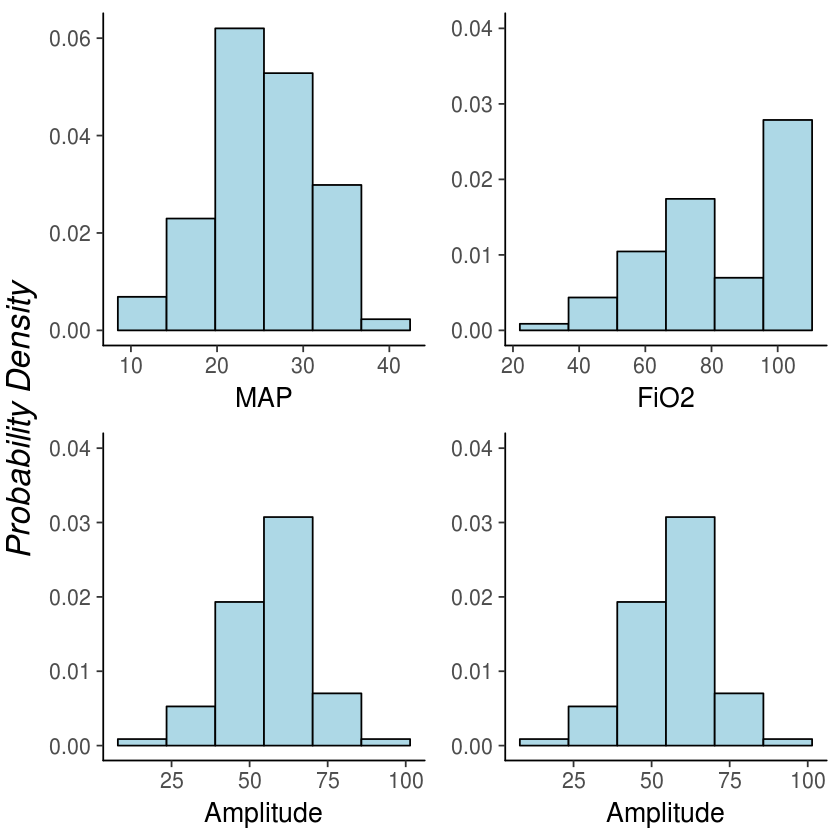

In [447]:

grid.arrange(p_map,p_fio2, p_amplitue,p_amplitue, ncol=2,
             left=textGrob("Probability Density",gp=gpar(fontsize=20,font=3),rot=90))


In [443]:
?grid.arrange

arrangeGrob {gridExtra},R Documentation
...,"grobs, gtables, ggplot or trellis objects"
grobs,list of grobs
layout_matrix,optional layout
vp,viewport
name,argument of gtable
as.table,logical: bottom-left to top-right (TRUE) or top-left to bottom-right (FALSE)
respect,argument of gtable
clip,argument of gtable
nrow,argument of gtable
ncol,argument of gtable


In [237]:
#sensitivity analysis for PS matching
mydata_wth_pscore<-data.frame(cbind(mydata,pscore))
m.out <- matchit(treatment~female+age+pim2+pelod+p_bloodculture+comorbidity+rf_pneumonia+rf_sepsis
                 +rf_aspiration+rf_transfusion+rf_trauma+rf_drowning+MODS+OI_category, data = mydata_wth_pscore,              
                 method = "nearest", distance=mydata_wth_pscore$pscore,caliper=0.1
                 ,ratio=1)


In [232]:
###################################
#outcome analysis for PS matching
y_treatment<-match.data(m.out)$mortality_28day[match.data(m.out, "all")$treatment==1] 
y_control<-match.data(m.out)$mortality_28day[match.data(m.out, "all")$treatment==0] 
#head(mydata)
#colnames(mydata)
#y_treatment<-mydata$mortality_28day[mydata$treatment==1] 
#y_control<-mydata$mortality_28day[mydata$treatment==0] 
length(y_treatment)
length(y_control)
#y_treatment
#table(y_treatment,y_control)
#McNemar test for PICU mortality
mcnemar.test(y_treatment, y_control)

########## calculate Odd's ratio here!
a<-length(y_treatment[y_treatment==1])
b<-length(y_control[y_control==1])
c<-length(y_treatment[y_treatment==0])
d<-length(y_control[y_control==0])

oddsratio(matrix(c(a,b,c,d), ncol=2, nrow=2))

[1] 83

[1] 83


	McNemar's Chi-squared test with continuity correction

data:  y_treatment and y_control
McNemar's chi-squared = 4.1143, df = 1, p-value = 0.04252


,Disease1,Disease2,Total
Exposed1,30,53,83
Exposed2,17,66,83
Total,47,119,166
,estimate,lower,upper
Exposed1,1.000000,NA,NA
Exposed2,2.180132,1.093058,4.463514
,midp.exact,fisher.exact,chi.square
Exposed1,NA,NA,NA
Exposed2,0.02672973,0.03808355,0.02511539


In [116]:
#other MSM model
df2$wt<-time_model$weights.trunc
df2$historical_treatment<-cumsum(df2$HFV_indicator)
msm<-svyglm(event~historical_treatment, design=svydesign(~1,weights=~df2$wt,data=df2
                                                                 ))
beta<-coef(msm)
ci<-confint(msm)
ci

causalrr<-exp(beta[2])
lcl<-exp(ci[2])
ucl<-exp(ci[4])
c(lcl, causalrr, ucl)
summary(msm)

,2.5 %,97.5 %
(Intercept),1.254713e-02,2.823532e-02
historical_treatment,-3.946796e-05,5.292585e-06


historical_treatment                      
           0.9999605            0.9999829            1.0000053


Call:
svyglm(formula = event ~ historical_treatment, design = svydesign(~1, 
    weights = ~df2$wt, data = df2))

Survey design:
svydesign(~1, weights = ~df2$wt, data = df2)

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           2.039e-02  4.002e-03   5.095 3.61e-07 ***
historical_treatment -1.709e-05  1.142e-05  -1.496    0.135    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.0158338)

Number of Fisher Scoring iterations: 2


In [117]:
#other MSM model 2
df2$wt<-time_model$weights.trunc
#df2$historical_treatment<-cumsum(df2$HFV_indicator)
msm<-svyglm(event~HFV_indicator, design=svydesign(ids=~ID,weights=~df2$wt,data=df2
                                                                 ))
beta<-coef(msm)
ci<-confint(msm)
ci

causalrr<-exp(beta[2])
lcl<-exp(ci[2])
ucl<-exp(ci[4])
c(lcl, causalrr, ucl)
summary(msm)

,2.5 %,97.5 %
(Intercept),0.01244510,0.020761664
HFV_indicator,-0.01624464,0.006665096


HFV_indicator               
    0.9838866     0.9952217     1.0066874


Call:
svyglm(formula = event ~ HFV_indicator, design = svydesign(ids = ~ID, 
    weights = ~df2$wt, data = df2))

Survey design:
svydesign(ids = ~ID, weights = ~df2$wt, data = df2)

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    0.016603   0.002122   7.826 7.11e-14 ***
HFV_indicator -0.004790   0.005844  -0.820    0.413    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.01583986)

Number of Fisher Scoring iterations: 2


In [13]:
#create weights
weight<-ifelse(treatment==1, 1/pscore, 1/(1-pscore))

#apply weights to data
weighteddata<-svydesign(ids=~1, data = mydata, weights = ~weight)

#weighted table 1
weightedtable <- svyCreateTableOne(vars=xvars, strata="treatment", data=weighteddata, test = FALSE)

#Show table with SMD
print(weightedtable, smd=TRUE)

                            Stratified by treatment
                             0              1              SMD   
  n                          380.83         318.38               
  female (mean (sd))           0.39 (0.49)    0.46 (0.50)   0.142
  age (mean (sd))              4.83 (5.32)    3.99 (4.41)   0.172
  pim2 (mean (sd))            16.95 (18.72)  17.36 (20.11)  0.021
  pelod (mean (sd))           12.60 (11.21)  10.63 (9.62)   0.188
  p_bloodculture (mean (sd))   0.14 (0.35)    0.15 (0.36)   0.023
  comorbidity (mean (sd))      0.59 (0.49)    0.50 (0.50)   0.172
  rf_pneumonia (mean (sd))     0.80 (0.40)    0.77 (0.42)   0.067
  rf_sepsis (mean (sd))        0.38 (0.49)    0.35 (0.48)   0.060
  rf_aspiration (mean (sd))    0.09 (0.29)    0.03 (0.18)   0.228
  rf_transfusion (mean (sd))   0.01 (0.10)    0.01 (0.12)   0.040
  rf_trauma (mean (sd))        0.01 (0.10)    0.00 (0.00)   0.145
  rf_drowning (mean (sd))      0.03 (0.17)    0.04 (0.19)   0.034
  MODS (mean (sd))      

In [15]:
#to get a weighted mean for a single covariate directly
mean(weight[treatment==1]*age[treatment==1])/(mean(weight[treatment==1]))

[1] 3.518758

In [17]:
#get causal relative risk weighted GLM
glm.obj<-glm(died~treatment,weights=weight, family=binomial(link="log"))
#summary(glm.obj)
betaiptw<-coef(glm.obj)
#to properly account for weighting, use asymptotic variance
SE<-sqrt(diag(vcovHC(glm.obj, type="HC0")))

#get point estimate and CI for relative risk (need to exponentiate)
causalrr<-exp(betaiptw[2])
lcl<-exp(betaiptw[2]-1.96*SE[2])
ucl<-exp(betaiptw[2]+1.96*SE[2])
c(lcl, causalrr, ucl)

Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”

treatment treatment treatment 
0.8982137 1.3944506 2.1648438

In [18]:
#get causal risk difference for weighted GLM
#truncweight
#truncweight<-replace(weight,weight>10,10)

glm.obj<-glm(died~treatment,weights=weight, family=binomial(link="identity"))
#summary(glm.obj)
betaiptw<-coef(glm.obj)
#to properly account for weighting, use asymptotic variance
SE<-sqrt(diag(vcovHC(glm.obj, type="HC0")))

#get point estimate and CI for relative risk (need to exponentiate)
causalrr<-exp(betaiptw[2])
lcl<-exp(betaiptw[2]-1.96*SE[2])
ucl<-exp(betaiptw[2]+1.96*SE[2])
c(lcl, causalrr, ucl)

Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”

treatment treatment treatment 
0.9494288 1.1254270 1.3340504

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3538  0.7017  0.7992  0.9611  1.0147  4.4225 

,2.5 %,97.5 %
(Intercept),0.23954016,0.3989309
treatment,-0.06199562,0.2045047


treatment           
 0.939887  1.073855  1.226917

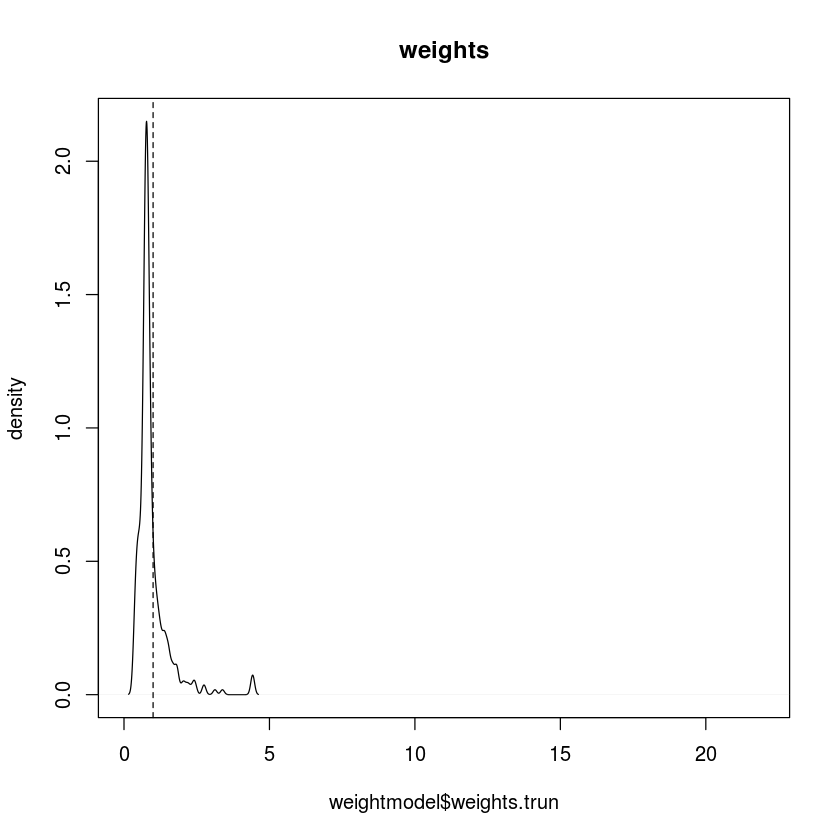

In [35]:
#same model using R package IPW
weightmodel<-ipwpoint(exposure=treatment, family="binomial", link="logit",numerator=~female+age,denominator=~female+age+pim2+pelod+p_bloodculture+comorbidity+rf_pneumonia+rf_sepsis
                 +rf_aspiration+rf_transfusion+rf_trauma+rf_drowning+MODS+OI,data=mydata, trunc=0.01)

#numeric summary of weights
summary(weightmodel$weights.trun)

#plot of weights
#ipwplot(weights=weightmodel$ipw.weights, logscale=FALSE, main="weights",xlim=c(0,22))
#plot of truncated weight
ipwplot(weights=weightmodel$weights.trun, logscale=FALSE, main="weights",xlim=c(0,22))
mydata$wt<-weightmodel$weights.trun
msm<-svyglm(died~treatment, design=svydesign(~1,weights=~wt,data=mydata))
beta<-coef(msm)
ci<-confint(msm)
ci

causalrr<-exp(beta[2])
lcl<-exp(ci[2])
ucl<-exp(ci[4])
c(lcl, causalrr, ucl)